In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.layers import *
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir('/content/drive/MyDrive/')

## Data preparing

In [51]:
data = pd.read_csv('final_data.csv')

In [52]:
data.drop('Unnamed: 0' ,axis=1, inplace=True)

In [53]:
data.head()

,Year,Month,Day,Hour,Air pressure,Air temperature,RAD radiation,Precipitation,Realtive humidity,UVB radiation,CO,NO2,NOx,O3,PM2.5,PM10,SO2,C6H6
0,2015,1,1,0,1012.0,-6.6,0.0,62.8,1.6,278.0,0.575,18.0,20.0,7.0,19.0,NaN,35.778146,5.01000
1,2015,1,1,1,1011.0,-7.4,0.0,69.6,1.5,279.0,0.581,20.0,25.0,7.0,13.0,50.0,244.272000,5.25388
2,2015,1,1,2,1011.0,-7.1,0.0,72.3,1.4,286.0,0.678,20.0,25.0,6.0,11.0,34.0,102.633000,4.74133
3,2015,1,1,3,1012.0,-6.5,0.2,71.0,1.5,292.0,0.686,21.0,24.0,6.0,9.0,29.0,77.725900,4.66580
4,2015,1,1,4,1012.0,-5.6,0.0,69.2,1.7,299.0,0.653,22.0,25.0,6.0,10.0,21.0,69.562100,4.77038


In [54]:
def prepare_data(data):
  #Preparing dataset for model
  data2015 = data[data.Year==2015]
  data_2015_by_day = data2015.groupby(['Month','Day']).mean()
  data_2015_by_day.reset_index(drop=True, inplace=True)
  data_2015_by_day.reset_index(drop=True, inplace=True)
  data_2015_by_day = data_2015_by_day['NOx']
  data2016 = data[data.Year==2016]
  data_2016_by_day = data2016.groupby(['Month','Day']).mean()
  data_2016_by_day.reset_index(drop=True, inplace=True)
  data_2016_by_day.reset_index(drop=True, inplace=True)
  data_2016_by_day = data_2016_by_day['NOx']
  data2017 = data[data.Year==2017]
  data_2017_by_day = data2017.groupby(['Month','Day']).mean()
  data_2017_by_day.reset_index(drop=True, inplace=True)
  data_2017_by_day.reset_index(drop=True, inplace=True)
  data_2017_by_day = data_2017_by_day['NOx']
  combine = [data_2015_by_day,data_2016_by_day,data_2017_by_day]
  data = pd.concat(combine)
  return data

In [55]:
data = prepare_data(data)

In [56]:
NOx_timestamp = np.arange(1,data.shape[0]+1)
NOx_by_day = data

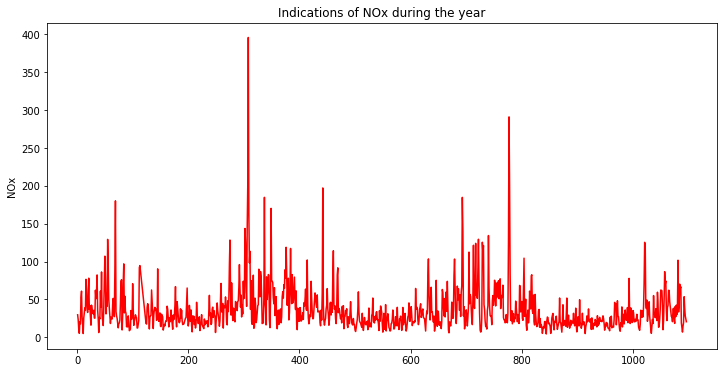

In [57]:
plt.figure(figsize=(12,6))
sns.lineplot(NOx_timestamp, NOx_by_day, color='red')
plt.title('Indications of NOx during the year')
plt.show()

In [58]:
NOx_by_day  = NOx_by_day[0:1092]

In [59]:
NOx_by_day = NOx_by_day.reset_index(drop=True)

In [60]:
train, test = NOx_by_day[0:728], NOx_by_day[728:1092]

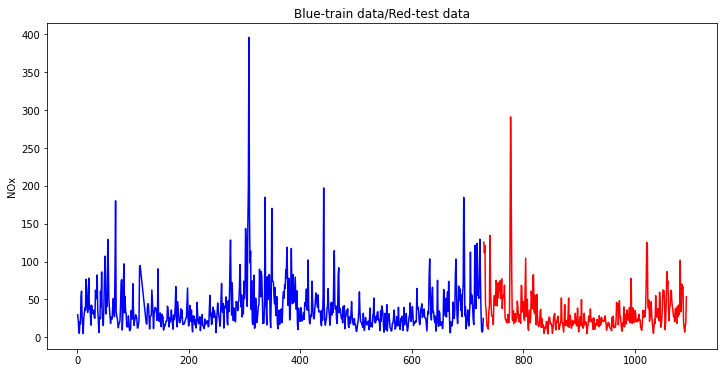

In [61]:
plt.figure(figsize=(12,6))
sns.lineplot(NOx_timestamp[0:728], train, color='blue')
sns.lineplot(NOx_timestamp[728:1092], test, color='red')
plt.title('Blue-train data/Red-test data')
plt.show()

## Naive forecasting

In [62]:
naive_forecast = NOx_by_day[728 - 1:1091]
validation = NOx_by_day[728:1092]

Text(0.5, 1.0, 'Naive annual forecasts for NOx')

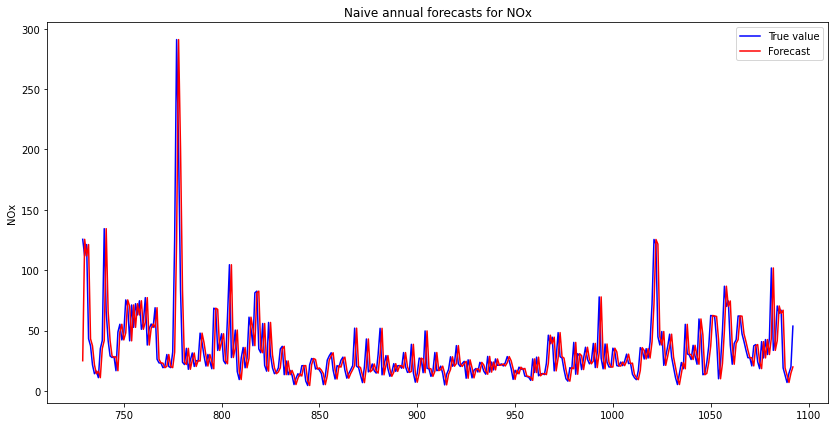

In [63]:
plt.figure(figsize=(14, 7))
ax1 = sns.lineplot(NOx_timestamp[728:1092], validation, color='blue', label='True value')
ax2 = sns.lineplot(NOx_timestamp[728:1092], naive_forecast, color='red', label='Forecast')
plt.title('Naive annual forecasts for NOx')

In [64]:
print('Annual RMSE: {}'.format(np.sqrt(mean_squared_error(validation, naive_forecast))))
print('Annual MAE: {}'.format(mean_absolute_error(validation, naive_forecast)))

Annual RMSE: 23.33550267356388
Annual MAE: 14.205294067765568


In [65]:
def daily_persistance(history):
  #Simple model performance indicator
  last_hours = np.array(history[:7])
  value = last_hours[-1]
  forecast = [value for _ in range(7)]
  return forecast

In [66]:
forecast = daily_persistance(test)
validation = test[7:14]

In [67]:
mse = mean_squared_error(validation,forecast)
mae = mean_absolute_error(validation,forecast)
print('RMSE: {}'.format(np.sqrt(mse)))
print('MAE: {}'.format(mae))

RMSE: 52.17083567175941
MAE: 36.100757797619046


## LSTM

In [68]:
train = np.array(np.split(train,len(train)/7))
test = np.array(np.split(test,len(test)/7))
train_features = [train for i in range(10)]

In [69]:
train = np.dstack(train_features)

In [70]:
def to_supervised(train, n_input, n_out=7):
  #Transform data for supervised learning problem
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	for _ in range(len(data)):
		in_end = in_start + n_input
		out_end = in_end + n_out
		if out_end <= len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		in_start += 1
	return np.array(X), np.array(y)

In [71]:
from keras.callbacks import Callback

In [72]:
class EarlyStoppingByLossVal(Callback):
#Early stopping callback for interruption of learning process at given loss.
    def __init__(self, monitor='loss', value=0.3, patience=3, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose
        self.patience = patience

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True

In [78]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

train_x, train_y = to_supervised(train, 7)
verbose, epochs, batch_size = 1, 100, 21
n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))

model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
model.add(RepeatVector(n_outputs))
model.add(LSTM(200, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(100, activation='relu')))
model.add(TimeDistributed(Dense(1)))
model.compile(loss='mse', optimizer=Adam(learning_rate=8e-6))

history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose, callbacks=lr_schedule)

Epoch 1/100
35/35 [==============================] - 3s 33ms/step - loss: 2456.9387
Epoch 2/100
35/35 [==============================] - 1s 33ms/step - loss: 2311.5656
Epoch 3/100
35/35 [==============================] - 1s 33ms/step - loss: 2420.1536
Epoch 4/100
35/35 [==============================] - 1s 32ms/step - loss: 2496.9479
Epoch 5/100
35/35 [==============================] - 1s 34ms/step - loss: 2324.2326
Epoch 6/100
35/35 [==============================] - 1s 34ms/step - loss: 2273.9481
Epoch 7/100
35/35 [==============================] - 1s 37ms/step - loss: 2610.0015
Epoch 8/100
35/35 [==============================] - 1s 33ms/step - loss: 2360.4365
Epoch 9/100
35/35 [==============================] - 1s 32ms/step - loss: 2578.0646
Epoch 10/100
35/35 [==============================] - 1s 35ms/step - loss: 2465.3434
Epoch 11/100
35/35 [==============================] - 1s 34ms/step - loss: 2179.5760
Epoch 12/100
35/35 [==============================] - 1s 33ms/step - loss:

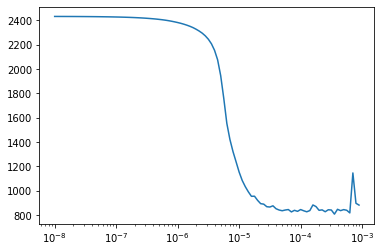

In [79]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])

In [80]:
def build_model(train, n_input):
  #Training model build
  es = EarlyStoppingByLossVal(monitor='loss')
  train_x, train_y = to_supervised(train, n_input)
  verbose, epochs, batch_size = 1, 1500, 21
  n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
  train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))

  model = Sequential()
  model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
  model.add(RepeatVector(n_outputs))
  model.add(LSTM(200, activation='relu', return_sequences=True))
  model.add(TimeDistributed(Dense(100, activation='relu')))
  model.add(TimeDistributed(Dense(1)))
  model.compile(loss='mse', optimizer=Adam(learning_rate=0.0001))

  history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose, callbacks=es)
  return model, history

In [81]:
model = build_model(train, 7)

Epoch 1/1500
35/35 [==============================] - 4s 34ms/step - loss: 2380.4101
Epoch 2/1500
35/35 [==============================] - 1s 32ms/step - loss: 1110.7906
Epoch 3/1500
35/35 [==============================] - 1s 33ms/step - loss: 1057.3423
Epoch 4/1500
35/35 [==============================] - 1s 33ms/step - loss: 889.0002
Epoch 5/1500
35/35 [==============================] - 1s 34ms/step - loss: 917.9557
Epoch 6/1500
35/35 [==============================] - 1s 33ms/step - loss: 940.7636
Epoch 7/1500
35/35 [==============================] - 1s 33ms/step - loss: 860.8579
Epoch 8/1500
35/35 [==============================] - 1s 32ms/step - loss: 805.1026
Epoch 9/1500
35/35 [==============================] - 1s 34ms/step - loss: 837.5682
Epoch 10/1500
35/35 [==============================] - 1s 34ms/step - loss: 843.9572
Epoch 11/1500
35/35 [==============================] - 1s 32ms/step - loss: 692.8686
Epoch 12/1500
35/35 [==============================] - 1s 33ms/step - l

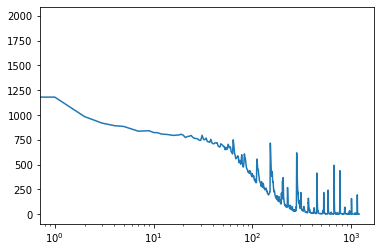

In [82]:
plt.semilogx(model[1].epoch, model[1].history['loss'])

In [83]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate_model(input, validation, model):
  #Model evaluation on test data
  input = input.values
  input = input.reshape(1,len(input), 1)
  validation = validation.values
  validation = validation.reshape(1,len(validation), 1)
  forecast = model[0].predict(input)
  days = ['Czwartek', 'Piatek', 'Sobota', 'Niedziela', 'Poniedzialek', 'Wtorek', 'Sroda', ]

  for i in range(validation.shape[1]):
    mse = mean_squared_error(validation[:, i], forecast[:, i])
    rmse = np.sqrt(mse)
    print('{} : RMSE:{}'.format(days[i],rmse))

  forecast = forecast.flatten()
  validation = validation.flatten()
  rmse = np.sqrt(mean_squared_error(validation, forecast))
  
  print('\nWeek RMSE:{}'.format(rmse))
  
  x = np.arange(1,8)
  plt.figure(figsize = (12,6))
  sns.lineplot(days, forecast.flatten(), label = 'Forecast', color='red')
  sns.lineplot(days, validation.flatten(), label = 'True value', color='blue')
  plt.show()

## Forecasts evaluations

Czwartek : RMSE:20.620060065104166
Piatek : RMSE:21.26364762776693
Sobota : RMSE:0.5563543518066467
Niedziela : RMSE:12.22155697733561
Poniedzialek : RMSE:91.72521681111652
Wtorek : RMSE:10.573520281982425
Sroda : RMSE:15.524550500488282

Week RMSE:37.40384237535614


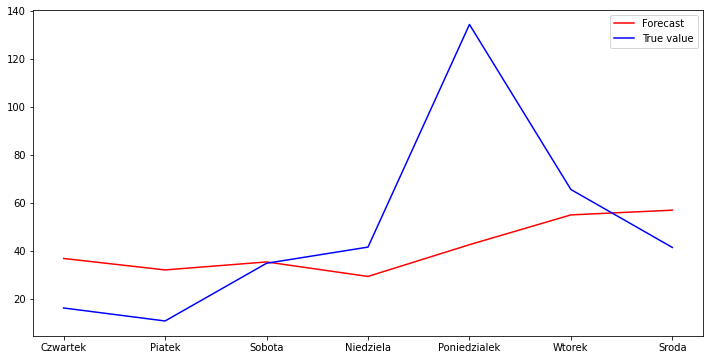

In [84]:
input = NOx_by_day[728:735]
validation = NOx_by_day[735:742]
evaluate_model(input, validation, model)

Czwartek : RMSE:4.362093466186522
Piatek : RMSE:11.682598684895826
Sobota : RMSE:34.934212917480465
Niedziela : RMSE:79.86055183186849
Poniedzialek : RMSE:39.27122718098957
Wtorek : RMSE:12.359134130859367
Sroda : RMSE:4.598223280843101

Week RMSE:36.780699676014954


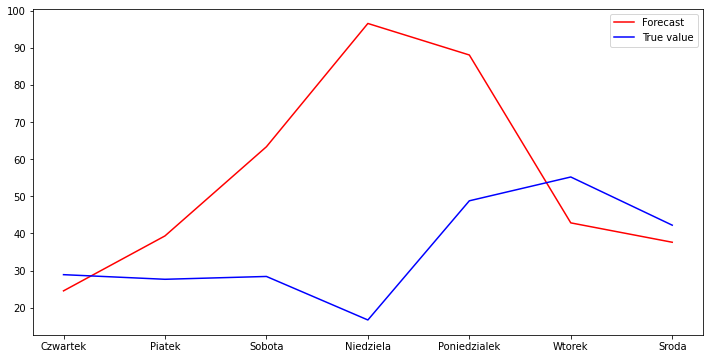

In [85]:
input1 = NOx_by_day[735:742]
validation1 = NOx_by_day[742:749]
evaluate_model(input1, validation1, model)

Czwartek : RMSE:10.789870853678387
Piatek : RMSE:29.028418961588542
Sobota : RMSE:7.133644140625009
Niedziela : RMSE:27.913918098958327
Poniedzialek : RMSE:15.883788997395854
Wtorek : RMSE:8.750253145345049
Sroda : RMSE:33.76942807617186

Week RMSE:21.575058610819767


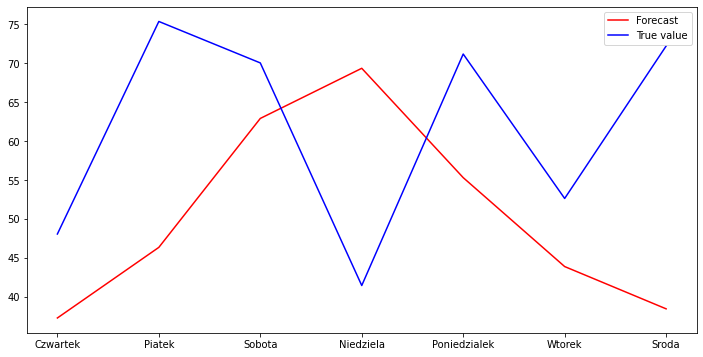

In [86]:
input2 = NOx_by_day[742:749]
validation2 = NOx_by_day[749:756]
evaluate_model(input2, validation2, model)

Czwartek : RMSE:15.479360371907553
Piatek : RMSE:32.04992604980468
Sobota : RMSE:28.228193183390296
Niedziela : RMSE:11.396947947184252
Poniedzialek : RMSE:46.93963626505533
Wtorek : RMSE:19.57019743957519
Sroda : RMSE:9.262453735351578

Week RMSE:26.36459964191741


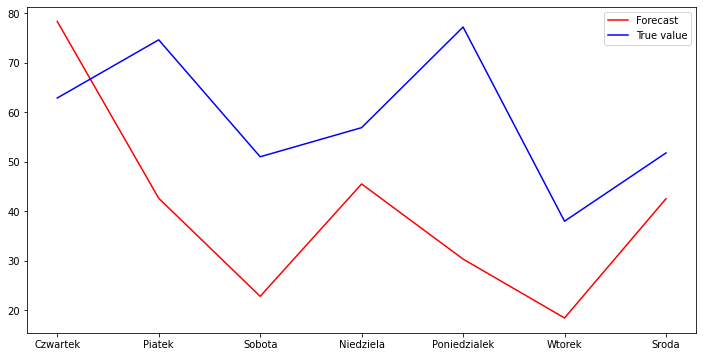

In [87]:
input3 = NOx_by_day[749:756]
validation3 = NOx_by_day[756:763]
evaluate_model(input3, validation3, model)

Czwartek : RMSE:5.842128926595052
Piatek : RMSE:23.654916728719094
Sobota : RMSE:25.626721484374997
Niedziela : RMSE:38.48612803955078
Poniedzialek : RMSE:18.659356245930994
Wtorek : RMSE:1.159377777099607
Sroda : RMSE:23.613422774251298

Week RMSE:22.799454657670285


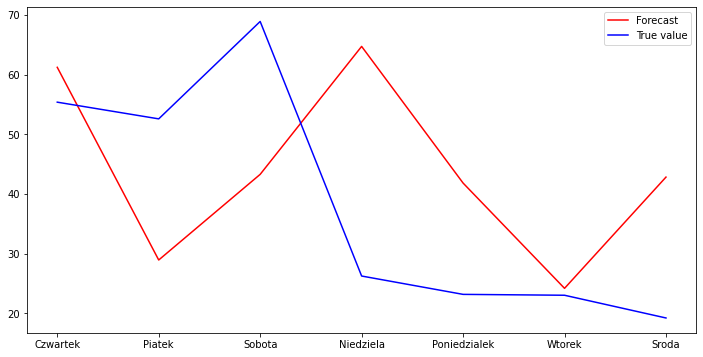

In [88]:
input4 = NOx_by_day[756:763]
validation4 = NOx_by_day[763:770]
evaluate_model(input4, validation4, model)

Czwartek : RMSE:7.39935537363688
Piatek : RMSE:8.345312965901694
Sobota : RMSE:21.26526322021485
Niedziela : RMSE:8.863020515950517
Poniedzialek : RMSE:16.78205262858073
Wtorek : RMSE:100.69665164082846
Sroda : RMSE:253.25798124186196

Week RMSE:103.65893060950384


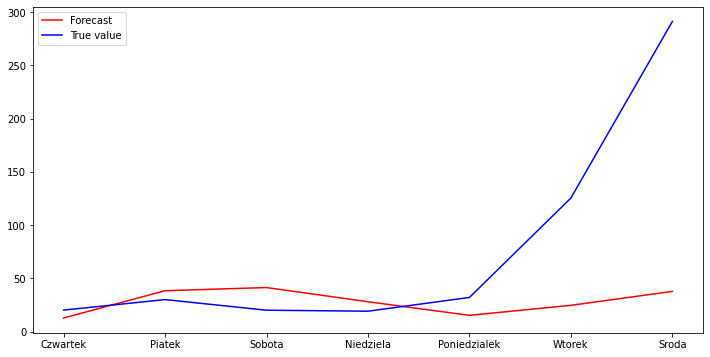

In [89]:
input5 = NOx_by_day[763:770]
validation5 = NOx_by_day[770:777]
evaluate_model(input5, validation5, model)

### Six last weeks

Czwartek : RMSE:28.999098338826485
Piatek : RMSE:15.054260822550454
Sobota : RMSE:17.117674377034504
Niedziela : RMSE:33.392748170979814
Poniedzialek : RMSE:23.694129838053385
Wtorek : RMSE:15.33381803771973
Sroda : RMSE:35.00012641906739

Week RMSE:25.346781969918492


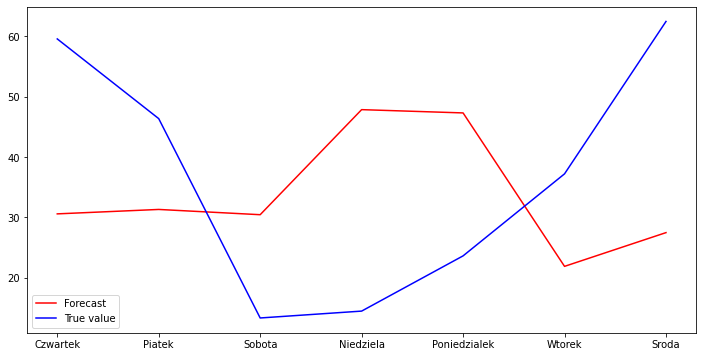

In [90]:
input7 = NOx_by_day[1036:1043]
validation7 = NOx_by_day[1043:1050]
evaluate_model(input7, validation7, model)

Czwartek : RMSE:13.898836201985667
Piatek : RMSE:5.966276774088534
Sobota : RMSE:12.387657544962558
Niedziela : RMSE:25.623776495768226
Poniedzialek : RMSE:40.2299568741862
Wtorek : RMSE:8.041910262044262
Sroda : RMSE:35.201075388590496

Week RMSE:23.787882710519096


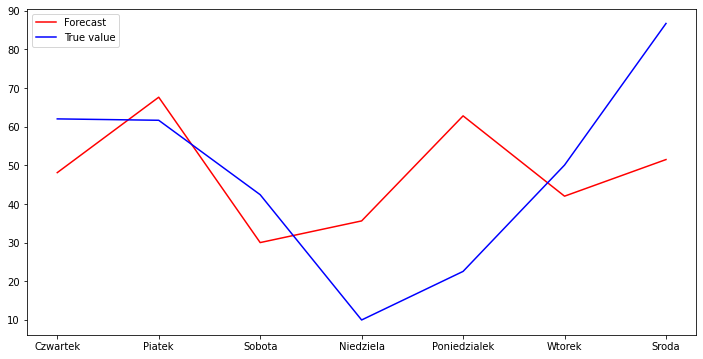

In [91]:
input8 = NOx_by_day[1043:1050]
validation8 = NOx_by_day[1050:1057]
evaluate_model(input8, validation8, model)

Czwartek : RMSE:16.259652437337238
Piatek : RMSE:16.285567964680993
Sobota : RMSE:17.147583833821614
Niedziela : RMSE:40.658350705566406
Poniedzialek : RMSE:25.93425325927734
Wtorek : RMSE:29.512066813964843
Sroda : RMSE:24.85605456542968

Week RMSE:25.740763011939706


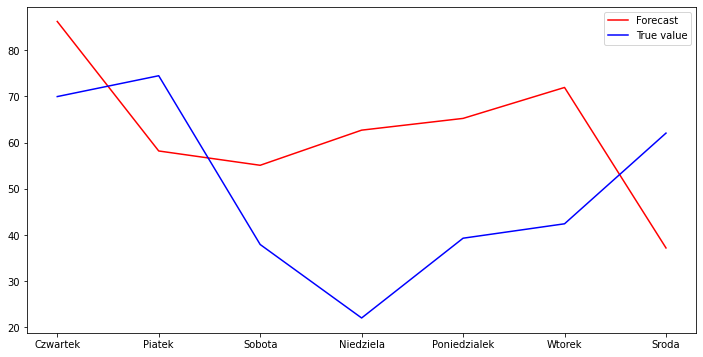

In [92]:
input9 = NOx_by_day[1050:1057]
validation9 = NOx_by_day[1057:1064]
evaluate_model(input9, validation9, model)

Czwartek : RMSE:34.785650756835935
Piatek : RMSE:17.473950472005214
Sobota : RMSE:4.464083542887373
Niedziela : RMSE:1.8599738667805994
Poniedzialek : RMSE:4.869114585367843
Wtorek : RMSE:2.2155520812988243
Sroda : RMSE:20.99822334716797

Week RMSE:16.93816620174508


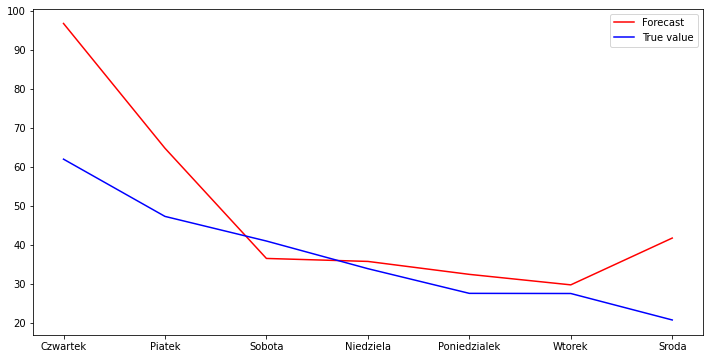

In [93]:
input10 = NOx_by_day[1057:1064]
validation10 = NOx_by_day[1064:1071]
evaluate_model(input10, validation10, model)

Czwartek : RMSE:28.997794146931966
Piatek : RMSE:0.16425336629230713
Sobota : RMSE:17.18337072794596
Niedziela : RMSE:39.303050965983076
Poniedzialek : RMSE:1.106206636962888
Wtorek : RMSE:7.875100672200521
Sroda : RMSE:12.234531937459316

Week RMSE:20.33231686894585


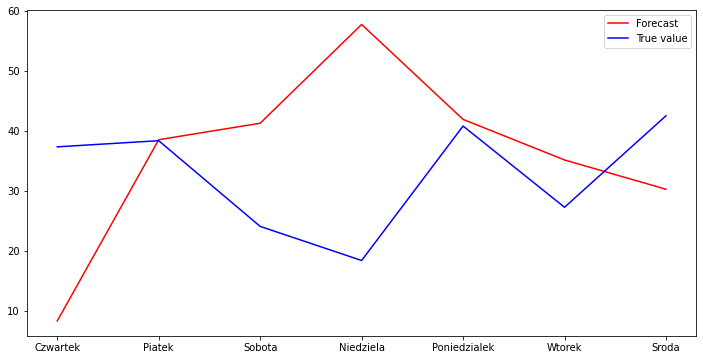

In [94]:
input11 = NOx_by_day[1064:1071]
validation11 = NOx_by_day[1071:1078]
evaluate_model(input11, validation11, model)

Czwartek : RMSE:34.22850794433593
Piatek : RMSE:13.535601993815106
Sobota : RMSE:59.301764404296875
Niedziela : RMSE:1.8484112609863317
Poniedzialek : RMSE:4.391356268717438
Wtorek : RMSE:16.01508481852214
Sroda : RMSE:33.574523959350586

Week RMSE:29.94741766545199


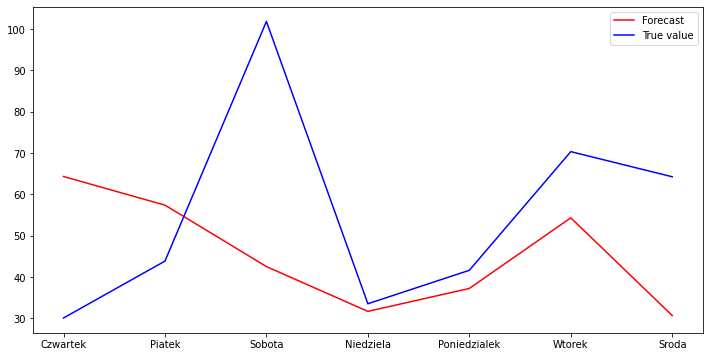

In [95]:
input12 = NOx_by_day[1071:1078]
validation12 = NOx_by_day[1078:1085]
evaluate_model(input12, validation12, model)

Czwartek : RMSE:14.131909922281906
Piatek : RMSE:33.06048880208333
Sobota : RMSE:31.184438428548177
Niedziela : RMSE:46.843130762125654
Poniedzialek : RMSE:60.75153920166016
Wtorek : RMSE:69.27983180745443
Sroda : RMSE:11.210671598307279

Week RMSE:43.21966924232332


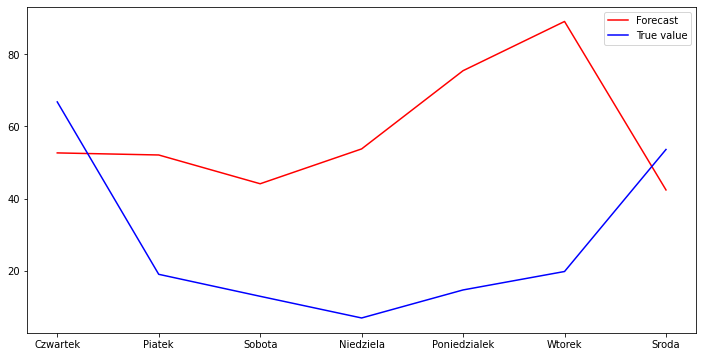

In [96]:
input13 = NOx_by_day[1078:1085]
validation13 = NOx_by_day[1085:1092]
evaluate_model(input13, validation13, model)

## How model learn ?

Czwartek : RMSE:0.28184254964192235
Piatek : RMSE:0.2387034098307268
Sobota : RMSE:0.0077362060546875
Niedziela : RMSE:0.2465928395589181
Poniedzialek : RMSE:0.6787624359130859
Wtorek : RMSE:0.026384989420570548
Sroda : RMSE:0.1265970865885464

Week RMSE:0.3104659752384709


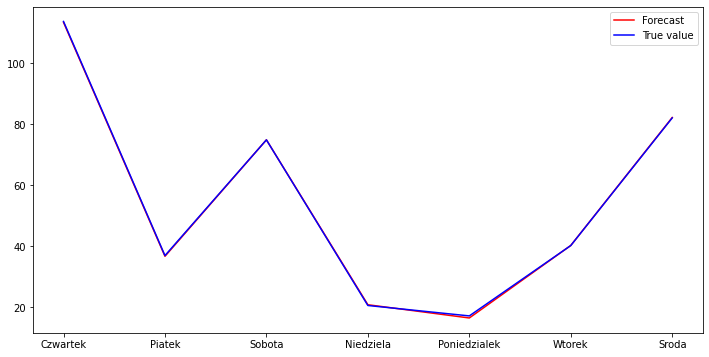

In [97]:
input = NOx_by_day[303:310]
validation = NOx_by_day[310:317]
evaluate_model(input, validation, model)

Czwartek : RMSE:0.13732655843098485
Piatek : RMSE:0.04664484659830492
Sobota : RMSE:0.87310791015625
Niedziela : RMSE:0.2438863118489678
Poniedzialek : RMSE:1.3555399576823106
Wtorek : RMSE:0.5682932535807197
Sroda : RMSE:0.5802027384440152

Week RMSE:0.6907463145950017


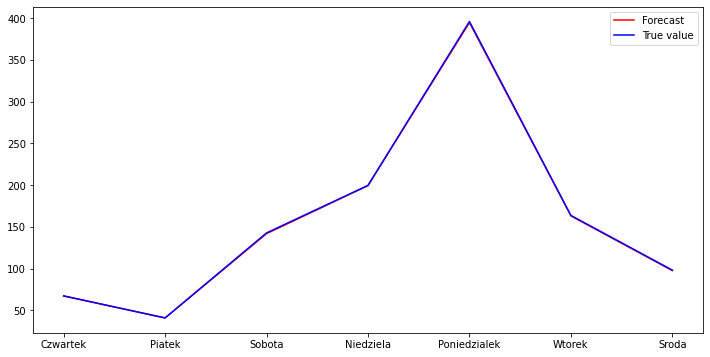

In [98]:
input = NOx_by_day[296:303]
validation = NOx_by_day[303:310]
evaluate_model(input, validation, model)

## NOx annual forecast obtained with LSTM

In [101]:
first_week = np.array([129.51810833, 74.31951875, 32.47322208, 9.57757208, 6.99435833, 8.30821625, 24.979625])

def annual_forecast(test_data, first_week):
  first_week = first_week.reshape(1,7,1)
  forecasts = []
  autoregressive = []
  validation = test_data
  forecasts.append(model[0].predict(first_week))
  autoregressive.append(forecasts[0])

  for i in range(51):
    if i == 0:
      first_forecast = forecasts[0].reshape(1,7,1)
      autoregressive.append(model[0].predict(first_forecast))
    else:
      reshape = autoregressive[i].reshape(1,7,1)
      autoregressive.append(model[0].predict(autoregressive[i]))

  for i in validation:
    i = i.reshape(1,7,1)
    forecasts.append(model[0].predict(i))

  forecasts.pop()
  forecasts = (np.array(forecasts)).flatten()
  autoregressive = (np.array(autoregressive)).flatten()
  validation = test_data.flatten()
  days = np.arange(1, len(forecasts)+1)
  plt.figure(figsize = (18,10))
  sns.lineplot(days, forecasts.flatten(), label = 'Forecast', color='red')
  sns.lineplot(days, validation.flatten(), label = 'True value', color='blue')
  # sns.lineplot(days, autoregressive.flatten(), label = 'Autoregression', color='green')
  plt.xlabel('Day of year', fontsize=12)
  plt.ylabel('NOx', fontsize=12)
  plt.title('Annual forecasts for NOx', fontsize=16)
  print('Annual RMSE: {}'.format(np.sqrt(mean_squared_error(validation, forecasts))))
  print('Annual MAE: {}'.format(mean_absolute_error(validation, forecasts)))
  plt.show()

Annual RMSE: 29.588679797334294
Annual MAE: 19.360307310717307


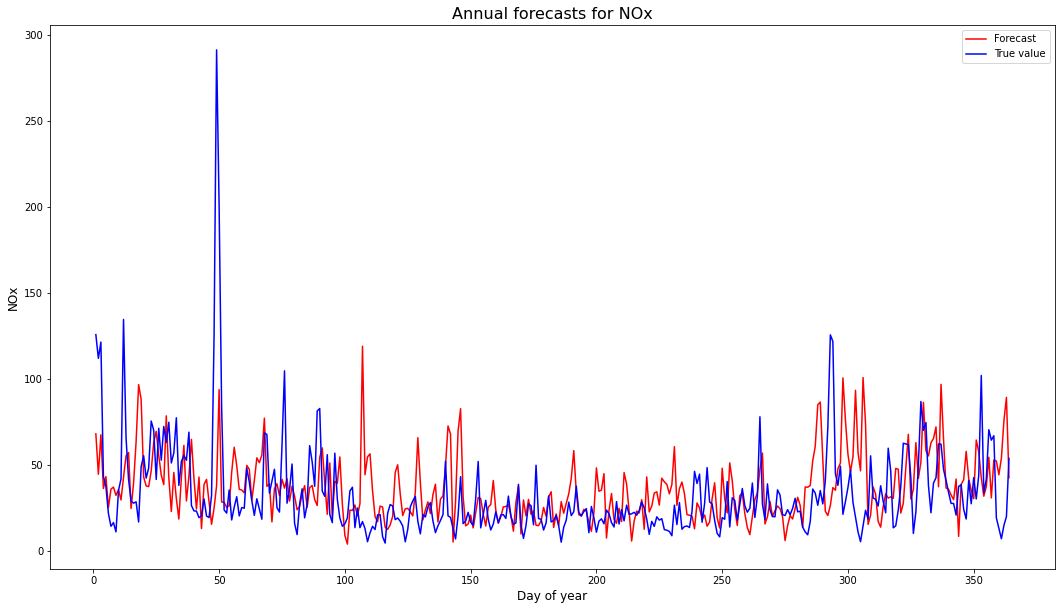

In [102]:
annual_forecast(test, first_week)